The model

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_data(
    ticker,
    start="2017-01-01"
):
    df = yf.download(
        ticker,
        start=start,
        auto_adjust=True,
        progress=False
    )

    df = df[["Open", "High", "Low", "Close", "Volume"]]
    df.dropna(inplace=True)

    return df

In [3]:
ticker = "AAPL"
stock = load_data(ticker)
qqq = load_data("QQQ")
data = stock.join(
    qqq[["Close"]],
    how="inner"
)
data.columns = ["_".join(col).strip() for col in data.columns]

In [4]:
data.tail()

,Open_AAPL,High_AAPL,Low_AAPL,Close_AAPL,Volume_AAPL,Close_QQQ
Date,,,,,,
2026-02-03,269.200012,271.880005,267.609985,269.480011,64394700,616.520020
2026-02-04,272.290009,278.950012,272.290009,276.489990,90545700,605.750000
2026-02-05,278.130005,279.500000,273.230011,275.910004,52977400,597.030029
2026-02-06,277.119995,280.910004,276.929993,278.119995,50453400,609.650024
2026-02-09,277.910004,278.200012,271.700012,274.619995,44562300,614.320007


In [5]:
def compute_rsi(series, window=14):
    delta = series.diff()

    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

In [6]:
def create_features_vw(df, symbol, window=20):
    data = df.copy()

    open = f"Open_{symbol}"
    close = f"Close_{symbol}"
    high = f"High_{symbol}"
    low = f"Low_{symbol}"
    volume = f"Volume_{symbol}"

    data["open"] = data[open]
    data["close"] = data[close]
    data["volume"] = data[volume]


    # Exponential moving average - weights more recent prices in an exponential manner
    # Ratio > 1 implies an upward trend
    data["ema_20"] = data["close"].ewm(span=20).mean()
    data["ema_ratio"] = data["close"] / data["ema_20"]

    # Bollinger Bands
    rolling_std = data["close"].rolling(20).std()
    data["bb_zscore"] = (data["close"] - data["ema_20"]) / rolling_std

    # Parkinson volatility (penalizing trades with high volatility)
    data["parkinson_vol"] = (
        np.log(data[high] / data[low]) ** 2
    ).rolling(window).mean()

    data["parkinson_z"] = (
        data["parkinson_vol"] - data["parkinson_vol"].rolling(50).mean()
    ) / data["parkinson_vol"].rolling(50).std()

    # Volatility penalty factor
    # High vol → smaller effective target
    data["vol_penalty"] = np.exp(-data["parkinson_z"].clip(lower=0))


    # QQQ ETF returns
    data["qqq_return"] = data["Close_QQQ"].pct_change()

    # Relative strength index (overbought or oversold?)
    data["rsi_14"] = compute_rsi(data["close"], window=14)

    # Target meaningful next-day move (will it go up)
    data["future_return_raw"] = data["close"].shift(-1) / data["close"] - 1
    data["future_return"] = data["future_return_raw"] * data["vol_penalty"]
    data["positive_change"] = (data["future_return"] > 0.002).astype(int)

    return data.dropna()


In [7]:
feature_df = create_features_vw(data, ticker)

In [8]:
feature_df.tail()

,Open_AAPL,High_AAPL,Low_AAPL,Close_AAPL,Volume_AAPL,Close_QQQ,open,close,volume,ema_20,ema_ratio,bb_zscore,parkinson_vol,parkinson_z,vol_penalty,qqq_return,rsi_14,future_return_raw,future_return,positive_change
Date,,,,,,,,,,,,,,,,,,,,
2026-02-02,260.029999,270.489990,259.209991,270.010010,73913400,626.140015,260.029999,270.010010,73913400,259.712810,1.039648,1.676067,0.000546,2.213379,0.109331,0.006866,61.417890,-0.001963,-0.000215,0
2026-02-03,269.200012,271.880005,267.609985,269.480011,64394700,616.520020,269.200012,269.480011,64394700,260.643019,1.033905,1.392929,0.000539,1.992589,0.136342,-0.015364,59.924680,0.026013,0.003547,1
2026-02-04,272.290009,278.950012,272.290009,276.489990,90545700,605.750000,272.290009,276.489990,90545700,262.152255,1.054692,1.896636,0.000547,1.984853,0.137401,-0.017469,67.079980,-0.002098,-0.000288,0
2026-02-05,278.130005,279.500000,273.230011,275.910004,52977400,597.030029,278.130005,275.910004,52977400,263.462516,1.047246,1.462679,0.000562,2.050251,0.128703,-0.014395,68.742083,0.008010,0.001031,0
2026-02-06,277.119995,280.910004,276.929993,278.119995,50453400,609.650024,277.119995,278.119995,50453400,264.858467,1.050070,1.395486,0.000562,1.968290,0.139696,0.021138,74.160440,-0.012584,-0.001758,0


In [9]:
FEATURES = [
    "ema_ratio",
    "bb_zscore",
    "parkinson_vol",
    "qqq_return",
    "volume",
    "rsi_14"
]

X = feature_df[FEATURES]
y = feature_df["future_return"]


In [10]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

In [11]:
split = int(len(X) * 0.95)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

In [12]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVR(
        kernel="rbf",
        C=10,
        epsilon=0.001,
        gamma="scale"
    ))
])
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [13]:
directional_accuracy = np.mean(
    np.sign(y_pred) == np.sign(y_test)
)
tolerance = 0.002

close_accuracy = np.mean(
    np.abs(y_pred - y_test) < tolerance
)


In [14]:
combined_accuracy = np.mean(
    (np.sign(y_pred) == np.sign(y_test)) |
    (np.abs(y_pred - y_test) < tolerance)
)

In [15]:
print(f"Directional accuracy: {directional_accuracy:.2%}")
print(f"Close-enough accuracy: {close_accuracy:.2%}")
print(f"Combined accuracy: {combined_accuracy:.2%}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R²: {r2_score(y_test, y_pred):.3f}")

Directional accuracy: 46.85%
Close-enough accuracy: 13.51%
Combined accuracy: 47.75%
MAE: 0.0105
R²: -0.632


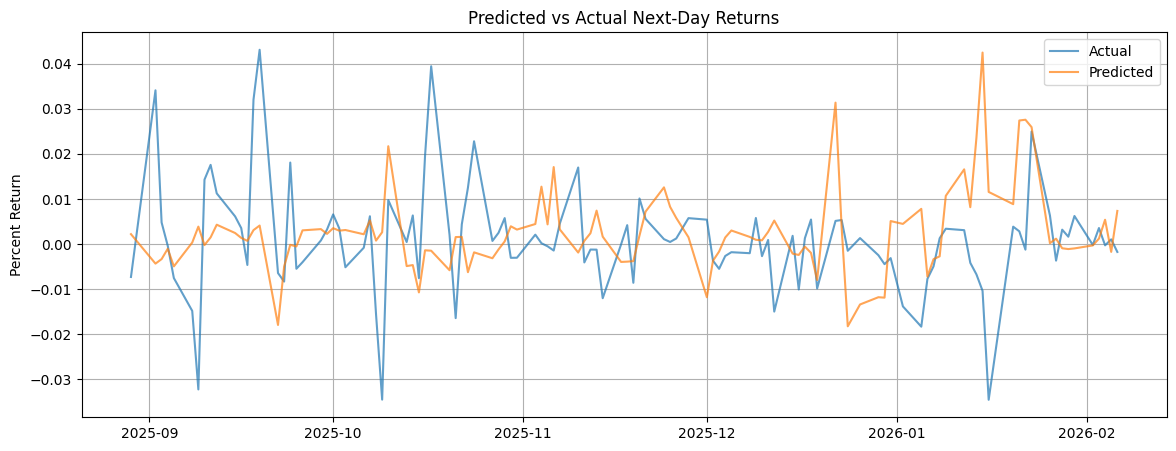

In [16]:
plot_df = pd.DataFrame({
    "Actual Return": y_test,
    "Predicted Return": y_pred
}, index=y_test.index)

plt.figure(figsize=(14, 5))
plt.plot(plot_df.index, plot_df["Actual Return"], label="Actual", alpha=0.7)
plt.plot(plot_df.index, plot_df["Predicted Return"], label="Predicted", alpha=0.7)

plt.title("Predicted vs Actual Next-Day Returns")
plt.ylabel("Percent Return")
plt.legend()
plt.grid(True)
plt.show()

Backtesting

In [17]:
def compute_trade_stats(equity_df, trades_df, initial_capital):
    stats = {}

    stats["total_trades"] = len(trades_df)

    if len(trades_df) == 0:
        return stats

    wins = trades_df[trades_df["pnl"] > 0]
    losses = trades_df[trades_df["pnl"] <= 0]

    stats["win_rate"] = len(wins) / len(trades_df)
    stats["avg_win"] = wins["pnl"].mean() if len(wins) > 0 else 0
    stats["avg_loss"] = losses["pnl"].mean() if len(losses) > 0 else 0

    stats["total_pnl"] = trades_df["pnl"].sum()
    stats["profit_factor"] = (
        wins["pnl"].sum() /
        abs(losses["pnl"].sum())
        if len(losses) > 0 else np.inf
    )

    returns = equity_df["equity"].pct_change().dropna()

    stats["sharpe"] = (
        np.sqrt(252) *
        returns.mean() /
        returns.std()
        if returns.std() > 0 else 0
    )

    stats["total_return"] = (
        equity_df["equity"].iloc[-1] /
        initial_capital - 1
    )

    stats["max_drawdown"] = equity_df["equity"].div(
        equity_df["equity"].cummax()
    ).min() - 1

    return stats


In [18]:
def backtest_strategy(
    df,
    initial_capital=100_000,
    max_trade_size=2_000
):
    capital = initial_capital
    position = 0
    entry_price = None

    equity = []
    trades = []

    peak_equity = initial_capital
    max_drawdown = 0

    for i in range(len(df) - 1):
        row = df.iloc[i]
        next_row = df.iloc[i + 1]

        open_price = next_row["open"]
        close_price = next_row["close"]

        # BUY
        if position == 0 and row["buy_signal"]:
            trade_cap = min(max_trade_size, capital)
            shares = int(trade_cap // open_price)

            if shares > 0:
                position = shares
                entry_price = open_price

        # SELL
        elif position > 0 and row["sell_signal"]:
            pnl = position * (close_price - entry_price)
            capital += pnl

            trades.append({
                "date": df.index[i],
                "shares": position,
                "entry": entry_price,
                "exit": close_price,
                "pnl": pnl,
                "return": pnl / (position * entry_price)
            })

            position = 0
            entry_price = None

        equity.append(capital)

        peak_equity = max(peak_equity, capital)
        drawdown = (capital - peak_equity) / peak_equity
        max_drawdown = min(max_drawdown, drawdown)

    equity_df = pd.DataFrame(
        equity,
        index=df.index[:-1],
        columns=["equity"]
    )

    trades_df = pd.DataFrame(trades)

    stats = compute_trade_stats(
        equity_df,
        trades_df,
        initial_capital
    )

    return equity_df, trades_df, stats

In [19]:
def print_backtest_report(stats):
    if not stats or stats.get("total_trades", 0) == 0:
        print("\nBACKTEST SUMMARY")
        print("-" * 40)
        print("No trades were executed.")
        print("-" * 40)
        return

    def pct(x):
        return f"{x * 100:6.2f}%" if x is not None else "  N/A "

    def num(x):
        return f"{x:8.2f}" if x is not None else "   N/A  "

    print("\nBACKTEST PERFORMANCE SUMMARY")
    print("=" * 45)

    print("\nReturns")
    print("-" * 45)
    print(f"Total Return:        {pct(stats['total_return'])}")
    print(f"Total PnL:           ${num(stats['total_pnl'])}")
    print(f"Sharpe Ratio:        {num(stats['sharpe'])}")
    print(f"Max Drawdown:        {pct(stats['max_drawdown'])}")

    print("\nTrades")
    print("-" * 45)
    print(f"Total Trades:        {stats['total_trades']:>8}")
    print(f"Win Rate:            {pct(stats['win_rate'])}")
    print(f"Avg Win:             ${num(stats['avg_win'])}")
    print(f"Avg Loss:            ${num(stats['avg_loss'])}")
    print(f"Profit Factor:       {num(stats['profit_factor'])}")

    print("=" * 45)

In [20]:
test_df = feature_df.iloc[split:]

# Predict on test set
X_test = test_df[FEATURES]
test_df["predicted_return"] = model.predict(X_test)

# Generate signals on test only
test_df["predicted_return_prev"] = test_df["predicted_return"].shift(1)

/tmp/ipython-input-715880368.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["predicted_return"] = model.predict(X_test)
/tmp/ipython-input-715880368.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["predicted_return_prev"] = test_df["predicted_return"].shift(1)


In [21]:
test_df["buy_signal"] = (
    (test_df["predicted_return"] > 0) &
    (test_df["rsi_14"].between(35, 65)) &
    (test_df["parkinson_z"] < 1.0)
)

test_df["sell_signal"] = (
    (test_df["predicted_return"] < 0) &
    (test_df["predicted_return"] < test_df["predicted_return_prev"])
)

# Backtest
equity_df, trades_df, stats = backtest_strategy(test_df)

# Statistics
print_backtest_report(stats)


BACKTEST PERFORMANCE SUMMARY

Returns
---------------------------------------------
Total Return:          0.31%
Total PnL:           $  309.46
Sharpe Ratio:            1.72
Max Drawdown:         -0.06%

Trades
---------------------------------------------
Total Trades:              10
Win Rate:             60.00%
Avg Win:             $   77.75
Avg Loss:            $  -39.25
Profit Factor:           2.97


/tmp/ipython-input-3439501512.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["buy_signal"] = (
/tmp/ipython-input-3439501512.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["sell_signal"] = (
